In [117]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, BasicAer, execute
from qiskit.aqua.utils.circuit_factory import CircuitFactory
from exp_a4 import A4Factory
from exp_a23 import A23Factory
from exp_a1 import A1Factory
import numpy as np
from qiskit.tools.visualization import circuit_drawer
from scipy.linalg import expm
%matplotlib inline
from qiskit.quantum_info.operators import Operator
from qiskit.aqua.circuits.gates import mct
# import FTSDFactory

In [118]:
class FTSDFactory(CircuitFactory):
    """
    When no time is provided the simulation runs for t=1. The target qubit is the less significant one.
    """
    def __init__(self, num_target_qubits=1):
        super().__init__(num_target_qubits)

    def required_ancillas(self):
        return 0

    def required_ancillas_controlled(self):
        return 0
    
    def build(self, qc, q, q_ancillas=None, params=1):
        pass
        # qc.u3(params, -np.pi/2, np.pi/2, q[0])

    def build_controlled(self, qc, q, q_control, q_ancillas=None, t=1, kj=1, coefficient = [], matrix_index = []):
        if len(coefficient) != len(matrix_index):
            exit("Error.")
        a1 = A1Factory(n)
        a23 = A23Factory(n)
        a4 = A4Factory(n)
        
        doU1 = False
        if doU1:
            for j in range(kj):
                for i in range(len(matrix_index)):
                    if matrix_index[i] == 0:
                        a1.build_controlled(qc, q, q_control, q_ancillas, coefficient[i]*t/kj)
                    elif matrix_index[i]==1:
                        a23.build_controlled(qc, q, q_control, q_ancillas, coefficient[i]*t/kj)
                    elif matrix_index[i]==2:
                        a4.build_controlled(qc, q, q_control, q_ancillas, coefficient[i]*t/kj)
                    else:
                        exit("Wrong matrix index: ", i)
        else:
            for j in range(kj):
                for i in range(len(matrix_index)):
                    if matrix_index[i] == 0:
                        a1.build_controlled(qc, q, q_control, q_ancillas, coefficient[i]*t/kj/2)
                    elif matrix_index[i]==1:
                        a23.build_controlled(qc, q, q_control, q_ancillas, coefficient[i]*t/kj/2)
                    elif matrix_index[i]==2:
                        a4.build_controlled(qc, q, q_control, q_ancillas, coefficient[i]*t/kj/2)
                    else:
                        exit("Wrong matrix index: ", i)
                for i in reversed(range(len(matrix_index))):
                    if matrix_index[i] == 0:
                        a1.build_controlled(qc, q, q_control, q_ancillas, coefficient[i]*t/kj/2)
                    elif matrix_index[i]==1:
                        a23.build_controlled(qc, q, q_control, q_ancillas, coefficient[i]*t/kj/2)
                    elif matrix_index[i]==2:
                        a4.build_controlled(qc, q, q_control, q_ancillas, coefficient[i]*t/kj/2)
                    else:
                        exit("Wrong matrix index: ", i)

    def build_inverse(self, qc, q, q_ancillas=None, params=1):
        pass
        # self.build(qc, q, q_ancillas, -params)

    def build_controlled_inverse(self, qc, q, q_control, q_ancillas=None, params=1):
        pass
        #self.build_controlled(qc, q, q_control, q_ancillas, -params)


In [119]:
def uni_matrix_factory(last_column):
    size = np.size(last_column)
    col = last_column.reshape((size, 1))
    a = np.zeros((size, size))

    a[:, [-1]] = col
    for i in range(size-1):
        a[:i+1, [i]] = col[:i+1]
        a[i+1, i] = - sum(col[:i+1]**2) / col[i+1]

    for i in range(size):
        a[:, i] = a[:, i] / np.sqrt(sum(a[:, i]**2))

    a = np.fliplr(a)

    if not check_power_of_a(a.shape[0], 2):
        b = np.zeros((2**n_sum, 2**n_sum))
        b[:size, :size] = a
        a = b
    
    for i in range(size, int(2**np.ceil(np.log2(size)))):
        a[i, i] = 1.
    
    a[np.isnan(a)] = 1

    return a

In [120]:
def check_power_of_a(n, a):
    if n == 1:
        return True
    elif n % a == 0:
        n = n / a
        check_power_of_a(n, a)
    else:
        return False

In [121]:
def dec2bin(decimal_number):
    binlist = []
    for i in range(len(bin(decimal_number))-2):
        binlist.append(int(bin(decimal_number)[2+i]))
    return binlist

def permutation_control(qc, q_control_list, i):
    binlist = dec2bin(i)
    for j in range(len(binlist)):
        if binlist[j]==1:
            qc.x(q_control_list[len(binlist)-j-1])

In [122]:
def put_mct(qc, qr_sum, qrac, n_toff, qrt=None):
    if n_toff > 0:
        qc.mct(qr_sum, qrac[0], qrt)
    elif n_sum == 2:
        qc.ccx(qr_sum[0], qr_sum[1], qrac)
    else:
        qc.cx(qr_sum[0], qrac)

In [123]:
# Need to optimize when the size of k is large (this function uses double loop.)
# arxiv:1907.11679 eq.5
# return: aj: list
def get_aj_from_kj(k):
    m = len(k)
    ret = []
    for j in range(m):
        if k[j] == 0.:
            ret.append(0)
        else:
            aj = 1.
            for q in range(m):
                if j == q: continue;
                aj *= 1 - np.square(k[q] / k[j])
            ret.append(1 / aj)
    return ret;

def fill_zeros(k_vec):
    for i in range(100):
        if len(k_vec) == 2**i:
            return k_vec
        elif len(k_vec) > 2**i:
            continue
        elif i==99:
            exit("Something strange")
        else:
            for j in range(len(k_vec), 2**i):
                k_vec.append(0)
            break
    return k_vec
            

In [124]:
def get_circuit_1907p11679(t, k_vec):
    # TODO: for sums with more than 2 elements need to change qr[n] by the right index
    #quantum register for the matrix
    qr = QuantumRegister(n, 'qr')
    qr_sum = QuantumRegister(n_sum, 'qr_sum')
    #ancilla qubits
    qra = QuantumRegister(n_ancilla, 'qra') if n_ancilla != 0 else QuantumRegister(1, 'qra')
    qrac = QuantumRegister(n_a_con, 'qrac')
    cr = ClassicalRegister(n+n_sum+n_ancilla+n_a_con, 'cr')
    
    if n_toff > 0:
        qrt = QuantumRegister(n_toff)
        qc = QuantumCircuit(qr, qr_sum, qra, qrac, qrt, cr)
    else:
        qc = QuantumCircuit(qr, qr_sum, qra, qrac, cr)

    #create unitary operations given its last column {a_j}

    #k_vec = fill_zeros(k_vec)
    a_vector = get_aj_from_kj(k_vec)
    a_vector = np.array(a_vector)
    #a_vector =  np.arange(1, 2**n_sum+1)# a_vector has to be a power of 2
    mat_A = uni_matrix_factory(a_vector)
    op_A = Operator(mat_A)
    op_B = Operator(mat_A.transpose())

    # encode coefficient information through A matrix
    qc.append(op_A, qr_sum)
    qc.barrier()

    for i_kj in range(len(k_vec)):
    #for i in range(2**n_sum):
        permutation_control(qc, qr_sum, i_kj)
        if n_toff > 0:
            put_mct(qc, qr_sum, qrac, n_toff, qrt)
        else:
            put_mct(qc, qr_sum, qrac, n_toff)
        FTSDFactory(n).build_controlled(qc, qr, qrac[0], qra, t=1, kj=k_vec[i_kj], coefficient=coefficient, matrix_index=matrix_index)
#         FTSDFactory(n).build_controlled(qc, qr, qrac[0], qra, t=1, kj=k_vec[i_kj], coefficient=coefficient, matrix_index=matrix_index[1])
        if n_toff > 0:
            put_mct(qc, qr_sum, qrac, n_toff, qrt)
        else:
            put_mct(qc, qr_sum, qrac, n_toff)
        permutation_control(qc, qr_sum, i_kj)
        qc.barrier()

    # invert A matrix
    qc.append(op_B, qr_sum)

    qc.barrier()
    # measurement of qr and qr_sum
#     qc.measure(qra, cr[0:n_ancilla])
#     qc.measure(qrac, cr[0:n_a_con])
    qc.measure(qr_sum, cr[n:n+n_sum])

    return qc

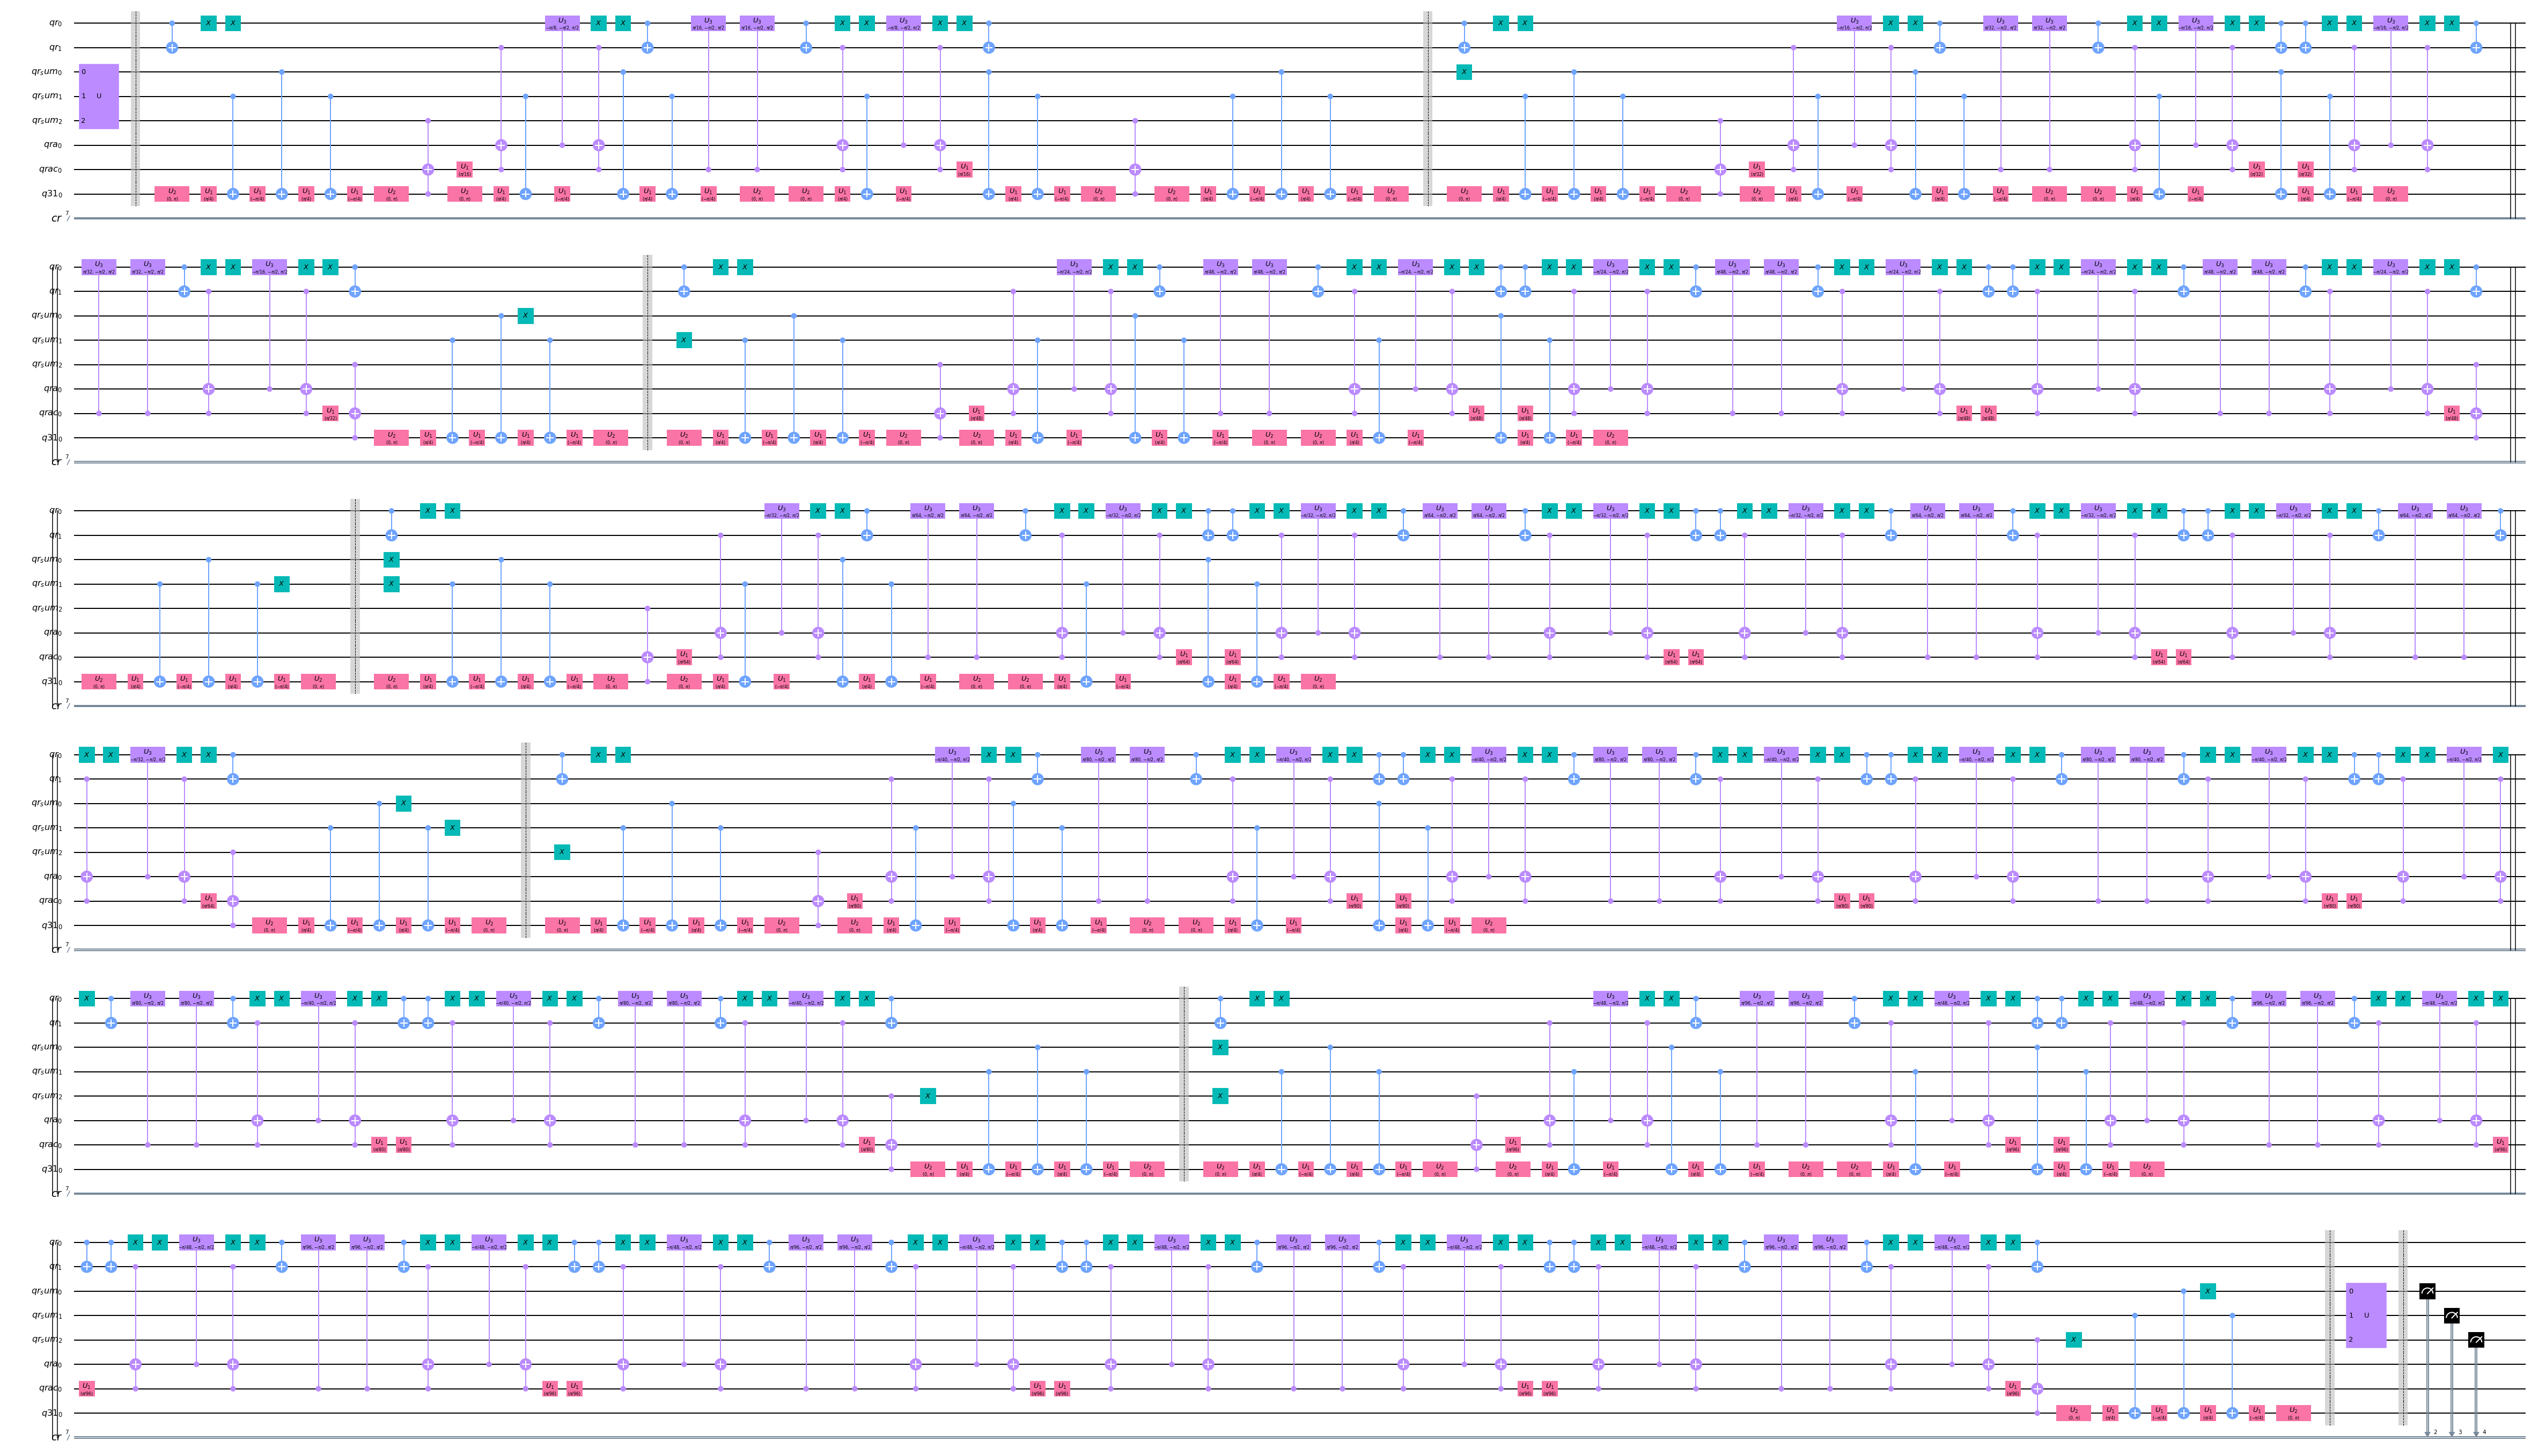

In [125]:
# print(qc)
# print(qr)
# print(qrac[0])
# print(qra)
qc = get_circuit_1907p11679(t=1, k_vec=k_vec)
qc.draw(output='mpl', fold=100)

In [12]:
# Optional: send the simulation to ibm's simulator
from qiskit import IBMQ
from qiskit import BasicAer
#IBMQ.load_account()
#provider = IBMQ.get_provider(hub='ibm-q-hub-ntu')
#backend = provider.get_backend('ibmq_qasm_simulator')
#backend = BasicAer.get_backend('qasm_simulator')

In [42]:
def get_approx_solution(t=1, k_vec=k_vec):
    # Obtain vector from the circuit
    backend = BasicAer.get_backend('statevector_simulator')
    # Create a quantum circuit
    qc = get_circuit_1907p11679(t=t, k_vec=k_vec)
    # Create a Quantum Program for execution 
    job = execute(qc, backend)
    # and store the result
    result = job.result()
    # Remember its an...a0qn..q0, where the a's are the ancilla
    svect = result.get_statevector(qc)
    
    # total number of qubits in the circuit
    lastq = n+n_sum+n_ancilla+n_a_con

    formatstr = "{0:0"+str(lastq)+"b}"
    # Final vector (i.e. approximate solution of e^iHt |x>)
    approx_sol = [0]*(2**n)
    
    #print("svect: ", svect)

    totalnorm= 0
    for i in range(0, len(svect)):
        # Only consider the entries where the sum qubits are 0 (i.e. successful circuit)
        if formatstr.format(i)[n:n+n_sum] == '0'*(n_sum):
            totalnorm += np.real(svect[i]*np.conjugate(svect[i]))
            index_bit = formatstr.format(i)[-n:][::-1]
            index_bit = ''.join(list(reversed(index_bit.strip())))
            current_index = int(index_bit, 2)
            approx_sol[current_index] += svect[i]

    approx_sol = approx_sol/np.sqrt(totalnorm)
    return approx_sol

In [155]:
def get_analytical_solution(t=1, initial_vector=np.append(1, [0]*((2**n)-1))):
    # analytical case
#     H23 = np.diag(np.append(np.array([0, b_2]*((2**(n-1))-1)),0), -1) + np.diag(np.append(np.array([0, b_2]*((2**(n-1))-1)),0), 1)
#     H4 = np.diag(np.append(np.array([b_4, 0]*((2**(n-1))-1)),b_4), -1) + np.diag(np.append(np.array([b_4, 0]*((2**(n-1))-1)),b_4), 1)

#     exact_exp = expm(1j*(H23+H4)*t)

#     test = np.dot(exact_exp, np.append(1,[0]*((2**n)-1)))
#     test /= np.linalg.norm(test)
#     return test

    H_sum = np.zeros(shape=[2**n, 2**n], dtype='float32')
    for i in range(len(matrix_index)):
        if matrix_index[i] == 0:
            b_1 = -coefficient[i]*t            
            H_sum += np.diag(np.array([b_1]*(2**n)))
        elif matrix_index[i]==1:
            b_2 = coefficient[i]*t
            H_sum += np.diag(np.append(np.array([0, b_2]*((2**(n-1))-1)),0), -1) + np.diag(np.append(np.array([0, b_2]*((2**(n-1))-1)),0), 1)
        elif matrix_index[i]==2:
            b_4 = coefficient[i]*t/2.
            H_sum += np.diag(np.append(np.array([b_4, 0]*((2**(n-1))-1)),b_4), -1) + np.diag(np.append(np.array([b_4, 0]*((2**(n-1))-1)),b_4), 1)
        else:
            exit("Wrong matrix index: ", i)
    
    #H_sum /= np.linalg.norm(H_sum, ord=2)
    exact_exp = expm(-1j * H_sum * t * 1.0)
    
    #exact_exp = exact_exp.transpose()

    ret = np.dot(exact_exp, initial_vector)
    ret /= np.linalg.norm(ret)
#     print('Exact H', H_sum)
    #print(exact_exp)
    
    # Some temporary hack
    #ret = ret.reshape([2**n, 2**n])
    
    return ret


## Test the fidelity for m = 10 (k_vec = [2, 3, ..., 11])

In [44]:
m = 2 # how many different U should be summed together
k_vec = []
for i in range(m):
    k_vec.append(2+i)

In [45]:
np.set_printoptions(precision=2)
approx = get_approx_solution(t=1, k_vec = k_vec)
exact = get_analytical_solution(t=1)
print("approx: ", approx)
print("exact: ", exact)

approx:  [9.06e-01+0.38j 7.29e-02-0.18j 3.50e-02+0.01j 7.39e-04-0.j  ]
exact:  [ 0.91+0.38j  0.07-0.18j -0.03-0.01j -0.  +0.j  ]


In [46]:
diff = abs(approx - exact)
sqr = 0
for i in range(len(diff)):
    sqr += diff[i]**2
distance = np.sqrt(sqr)
print('Fidelity is ', 1-distance)

Fidelity is  0.9241833400292377


## Prepare the plot of fidelity

In [161]:
fidelit_list = []
m_list = []
for j in range(9):
    
    m = j+2
    m_list.append(m)
    #     m = m_input
    k_vec = []
    for i in range(m):
        k_vec.append(1+i)
    #     print(k_vec)
    n_sum = int(np.ceil(np.log2(len(k_vec))))

    # number of ancilla qubits for the unitary operations themselves
    n_ancilla = n-1

    # number of ancilla qubits for controlling the unitary operations
    n_a_con = 1

    # number of ancilla qubits for multi-controlled toffoli
    n_toff = n_sum-2

    # Hamiltonian setting
    matrix_index = [0, 1, 2]  # 0:a1, 1:a23, 2:a4
    coefficient = [np.pi/8, np.pi/8, np.pi/8]  # params(e.g. theta) of each matrix
    
    approx = get_approx_solution(t=1, k_vec = k_vec)
    exact = get_analytical_solution(t=1)
    
    exact[2] *= -1
    exact[3] *= -1
    fidelity = 1-np.sqrt(np.sum(np.abs(approx-exact)**2))
    print(fidelity)
    fidelit_list.append(fidelity)

0.9973210985495289
0.9993971480713884
0.9980318398420338
0.9859063490954583
0.9997868913025202
0.9996219776732055
0.9990572443957892
0.8479492230690061
0.9989445757584894


In [162]:
print(fidelit_list)
print(m_list)

[0.9973210985495289, 0.9993971480713884, 0.9980318398420338, 0.9859063490954583, 0.9997868913025202, 0.9996219776732055, 0.9990572443957892, 0.8479492230690061, 0.9989445757584894]
[2, 3, 4, 5, 6, 7, 8, 9, 10]
